In [1]:
from numpy import save, asarray
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    HfArgumentParser,
    TrainingArguments,
    pipeline,
    logging,
)
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# The model that you want to train from the Hugging Face hub
model_name = "mistralai/Mistral-7B-v0.1"

# The instruction dataset to use
dataset_name = "RikoteMaster/Emotion_Recognition_4_llama2_chat"

# Fine-tuned model name
new_model = "mistral-7b-sentiment-analyzer"

################################################################################
# QLoRA parameters
################################################################################

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

################################################################################
# TrainingArguments parameters
################################################################################

# Output directory where the model predictions and checkpoints will be stored
output_dir = "./results_selected"

# Number of training epochs
num_train_epochs = 5

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

# Batch size per GPU for training
per_device_train_batch_size = 32

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 3e-5

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule (constant a bit better than cosine)
lr_scheduler_type = "constant"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 25

# Log every X updates steps
logging_steps = 25

################################################################################
# SFT parameters
################################################################################

# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [7]:
# Load dataset (you can process it here)
dataset = load_dataset(dataset_name, split="train")

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)

# Set training parameters
training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

# Set supervised fine-tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
    neftune_noise_alpha = 5
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)

Your GPU supports bfloat16: accelerate training with bf16=True


Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.77s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/usr/local/lib/python3.8/dist-packages/peft/utils/other.py:107: FutureWarning: prepare_model_for_int8_training is deprecated and will be removed in a future version. Use prepare_model_for_kbit_training instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/trl/trainer/sft_trainer.py:166: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, usin

Step,Training Loss
25,3.265900
50,1.871100
75,1.426000
100,0.912400
125,1.222300
150,0.789400
175,1.186400
200,0.751300
225,1.149500
250,0.734600


In [ ]:
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
accuracy = 0

ds = load_dataset("RikoteMaster/isear_for_llama2")

texts = ds['validation']['Text_processed']


labels = ds['validation']['Emotion']
 
     
label_detection = []
wrong_detection = []
corrects = 0
exceptions = 0
for sentence, label in zip(texts, labels):
    text = f"""<s>[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows:\n\n    Anger, Joy, Sadnes, Guilt, Shame, fear or disgust\n    \n    Sentence: {sentence} [/INST]"""
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=len(tokenizer(text)['input_ids']) + 5)
    result = pipe(text)
    try:
        detected = result[0]['generated_text'].split('[/INST]')[1].split()[0]
        if label != detected:
            print('Incorrect' + detected)
            wrong_detection.append(str(result) + " THE TRUE LABEL IS "+ label)
            label_detection.append(detected)
        else:
            corrects += 1
            print('correct')
            label_detection.append(detected)
    except:
   
    
        wrong_detection.append(str(result) + " THE TRUE LABEL IS " + label)
   
        exceptions += 1
    
import pandas as pd
# Crear la matriz de confusión
confusion = confusion_matrix(labels, label_detection)
    
# Convertir las etiquetas en una Serie de Pandas y obtener las etiquetas únicas
labels_series = pd.Series(labels)
unique_labels = labels_series.unique()
     
# Crear un gráfico de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()
     
# Calcular la precisión
correct_predictions = np.sum(np.diag(confusion))
total_predictions = np.sum(confusion)
accuracy = correct_predictions / total_predictions
     
print("Precisión:", accuracy)
#save results to txt
f = open("results.txt", "a")
f.write("Precisión:" + str(accuracy) + "\n")
f.close()

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/usr/local/lib/python3.8/dist-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectdisgust


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectjoy


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectsadness


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectfear


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectguilt


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectanger


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


correct


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Incorrectshame
Incorrectguilt


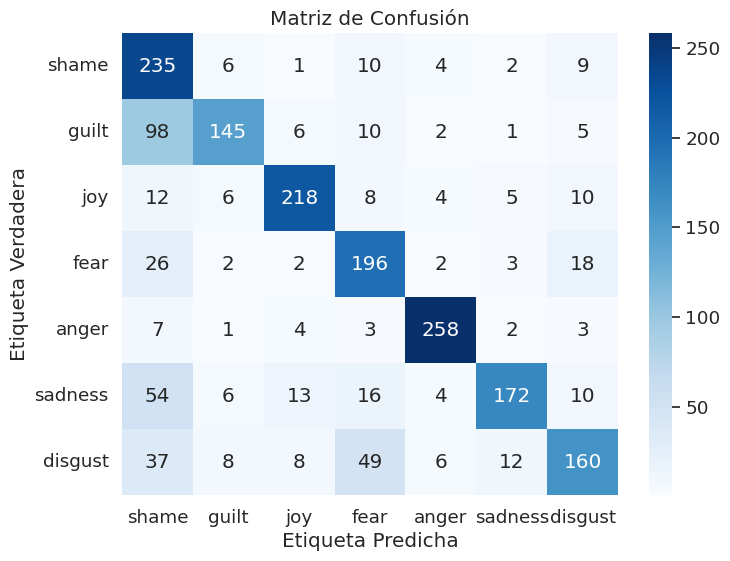

Precisión: 0.736562001064396


In [9]:
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
accuracy = 0

ds = load_dataset("RikoteMaster/isear_for_llama2")

texts = ds['test']['Text_processed']


labels = ds['test']['Emotion']
 
     
label_detection = []
wrong_detection = []
corrects = 0
exceptions = 0
for sentence, label in zip(texts, labels):
    text = f"""<s>[INST] In this task, you will be performing a classification exercise aimed at identifying the underlying emotion conveyed by a given sentence. The emotions to consider are as follows:\n\n    Anger, Joy, Sadnes, Guilt, Shame, fear or disgust\n    \n    Sentence: {sentence} [/INST]"""
    pipe = pipeline(task="text-generation", model=model, tokenizer=tokenizer, max_length=len(tokenizer(text)['input_ids']) + 5)
    result = pipe(text)
    try:
        detected = result[0]['generated_text'].split('[/INST]')[1].split()[0]
        if label != detected:
            print('Incorrect' + detected)
            wrong_detection.append(str(result) + " THE TRUE LABEL IS "+ label)
            label_detection.append(detected)
        else:
            corrects += 1
            print('correct')
            label_detection.append(detected)
    except:
   
    
        wrong_detection.append(str(result) + " THE TRUE LABEL IS " + label)
   
        exceptions += 1
    
import pandas as pd
# Crear la matriz de confusión
confusion = confusion_matrix(labels, label_detection)
    
# Convertir las etiquetas en una Serie de Pandas y obtener las etiquetas únicas
labels_series = pd.Series(labels)
unique_labels = labels_series.unique()
     
# Crear un gráfico de calor de la matriz de confusión
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Etiqueta Predicha')
plt.ylabel('Etiqueta Verdadera')
plt.title('Matriz de Confusión')
plt.show()
     
# Calcular la precisión
correct_predictions = np.sum(np.diag(confusion))
total_predictions = np.sum(confusion)
accuracy = correct_predictions / total_predictions
     
print("Precisión:", accuracy)
#save results to txt
f = open("results.txt", "a")
f.write("Precisión:" + str(accuracy) + "\n")
f.close()

In [14]:
model.push_to_hub('RikoteMaster/mistral_4_emotion_detection')

NotImplementedError: You are calling `save_pretrained` on a 4-bit converted model. This is currently not supported

In [1]:
import json
import transformers
from deep_translator import GoogleTranslator
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
def load_model(model_id, peft_model_id, load_in_8bit, device_map):
    model = AutoModelForCausalLM.from_pretrained(model_id, device_map=device_map, load_in_8bit=load_in_8bit)
    model.load_adapter(peft_model_id)
    return model

model_id = "mistralai/Mistral-7B-v0.1"
peft_model_id = "./mistral-7b-sentiment-analyzer"

model = load_model(model_id, peft_model_id, True, 'auto')

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.37s/it]


In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [9]:
model.push_to_hub("RikoteMaster/mistral_4_emotion_detection")

/usr/local/lib/python3.8/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)
adapter_model.bin: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109M/109M [00:06<00:00, 17.6MB/s]


CommitInfo(commit_url='https://huggingface.co/RikoteMaster/mistral_4_emotion_detection/commit/9f171dd301c3f4f5a0bd17e4617d8c55fd710aa9', commit_message='Upload MistralForCausalLM', commit_description='', oid='9f171dd301c3f4f5a0bd17e4617d8c55fd710aa9', pr_url=None, pr_revision=None, pr_num=None)